In [20]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

## Review

In [2]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

## New material

- **For today, you need not worry about the functions in this block of code.**
  - We will go over how all of these work within the next two classes

In [3]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', group='Color')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

- This code is super cool but it does not hold any conceptual value.

In [4]:
def plot_all_points(test_grid):
    test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);
    
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

def plot_all_points_classified(test_grid):
    c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)
    test_grid = test_grid.with_column('Class', c).join('Class', color_table)
    test_grid.scatter('Hemoglobin', 'Glucose', group='Color', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);

### What type of variable are we trying to predict?

- Today, they will be categorical. We will be doing a classification task.

#### Case study 1: hospital patients

In [5]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.sample(3).show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
60,80,1.025,0,0,normal,normal,notpresent,notpresent,81,15,0.5,141,3.6,15,46,10500,5.3,no,no,no,good,no,no,0
73,100,1.01,3,2,abnormal,abnormal,present,notpresent,295,90,5.6,140,2.9,9.2,30,7000,3.2,yes,yes,yes,poor,no,no,1
69,70,1.01,4,3,normal,abnormal,present,present,214,96,6.3,120,3.9,9.4,28,11500,3.3,yes,yes,yes,good,yes,yes,1


In [52]:
ckd.group('Class')

Class,count
0,115
1,43


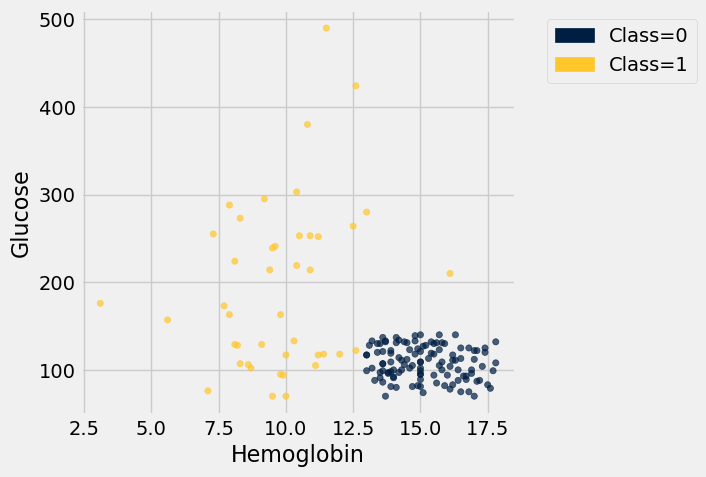

In [53]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

- We want to be able to way to predict the class of someone without having to plot & eye ball this graph every time.
    - One way to do this is to decide on a *classification threshold*.

In [7]:
max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

In [8]:
max_glucose_for_0

140

In [9]:
min_hemoglobin_for_0

13.0

In [10]:
def classify_manually(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

In [11]:
classify_manually(15, 100)

0

In [12]:
classify_manually(10, 300)

1

#### Case study 2: classifiying currency (bills)

In [13]:
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [14]:
banknotes.group('Class')

Class,count
0,762
1,610


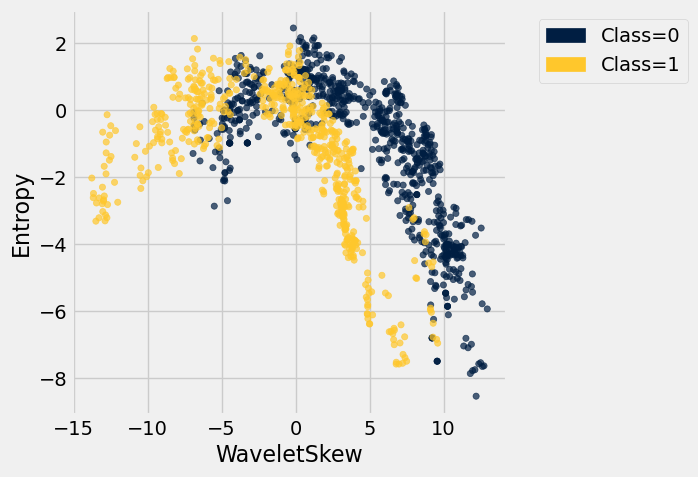

In [15]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Class')

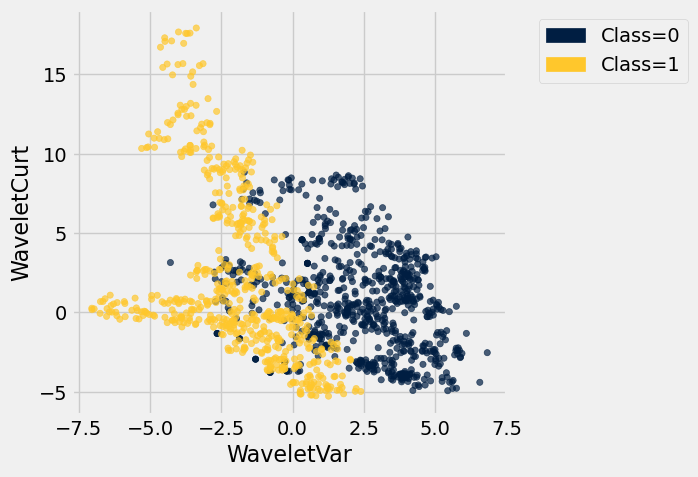

In [16]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

In [22]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

<Figure size 800x800 with 0 Axes>

### The Nearest Neighbor classifer

First, we convert our features into standard units.

In [23]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [24]:
color_table = Table().with_columns(
    'Class', make_array(0, 1),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

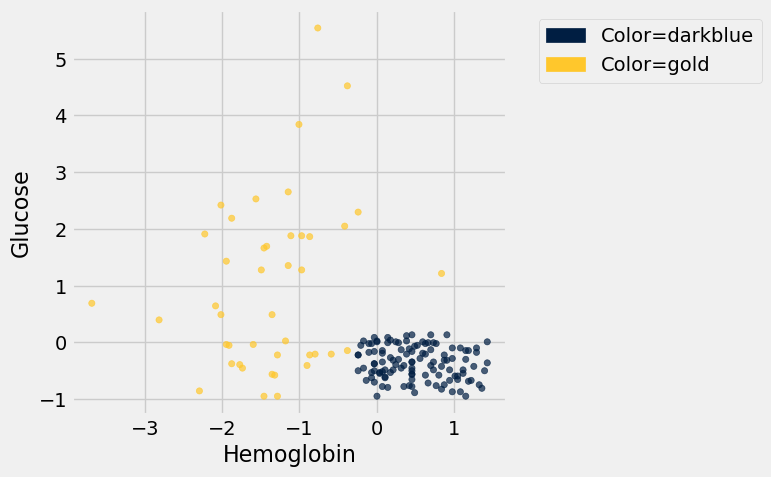

In [25]:
ckd.scatter('Hemoglobin', 'Glucose', group='Color')

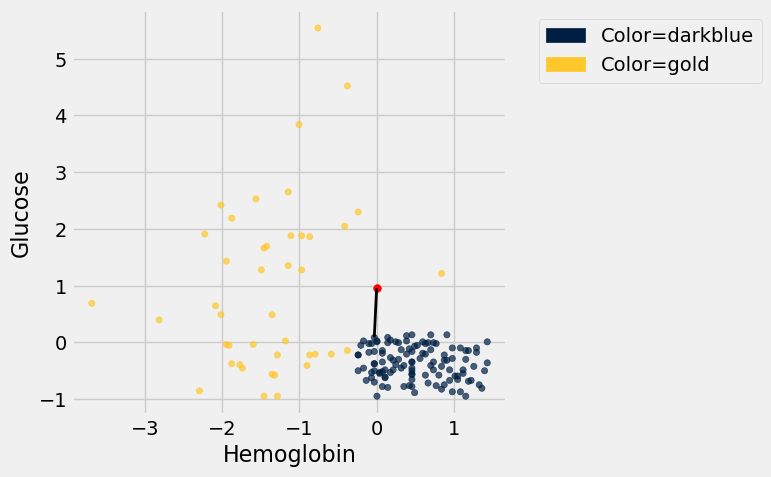

In [37]:
alice = make_array(0, 0.95)
show_closest(alice)

#### Decision boundaries are a great visualization tool for classification

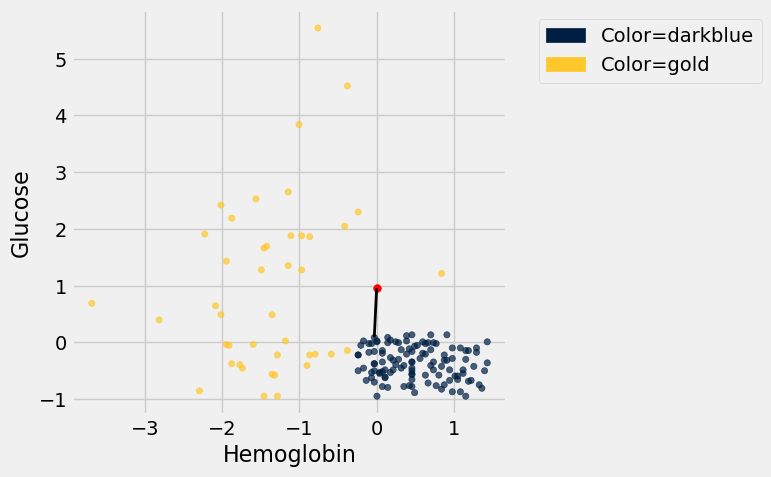

In [26]:
alice = make_array(0, 0.95)
show_closest(alice)

The boundary (visualized as a grid of points) is created with this block of code. 

In [27]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

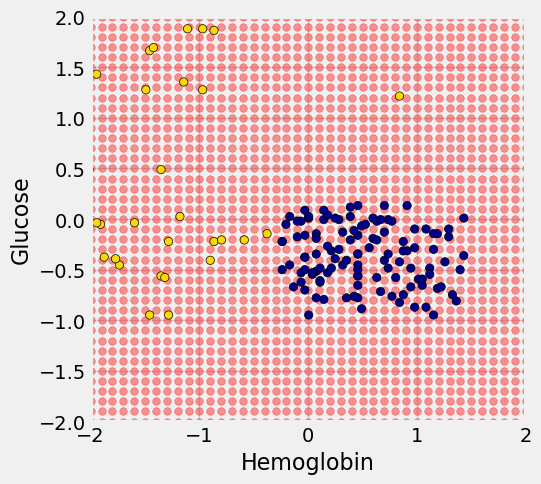

In [28]:
plot_all_points(test_grid)

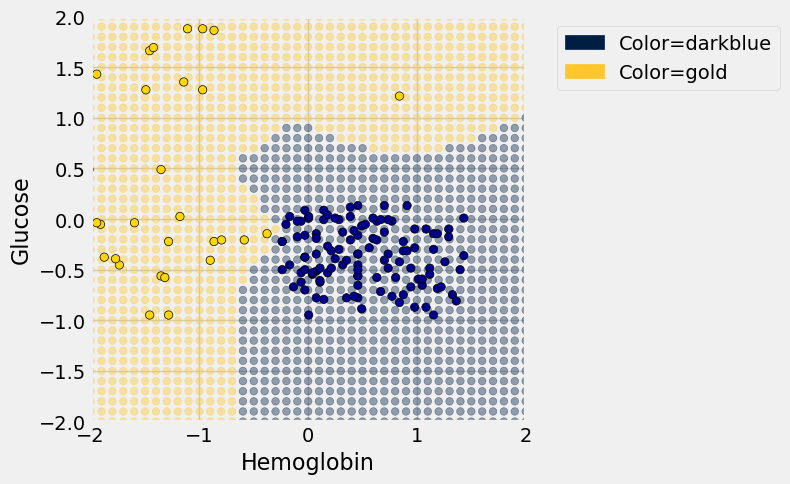

In [41]:
plot_all_points_classified(test_grid)

### Prediction is making informed guesses (on incomplete information)!

**Task**: Split the data from each of our case studies into training and testing sets.

- The training set and testing set need to be determined at random.
- In the following code, we are *permuting* the rows randomly and then extracting a test subset and training subset using `np.take()`. 

#### Case study 1

In [29]:
shuffled_ckd = ckd.sample(with_replacement=False)

training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

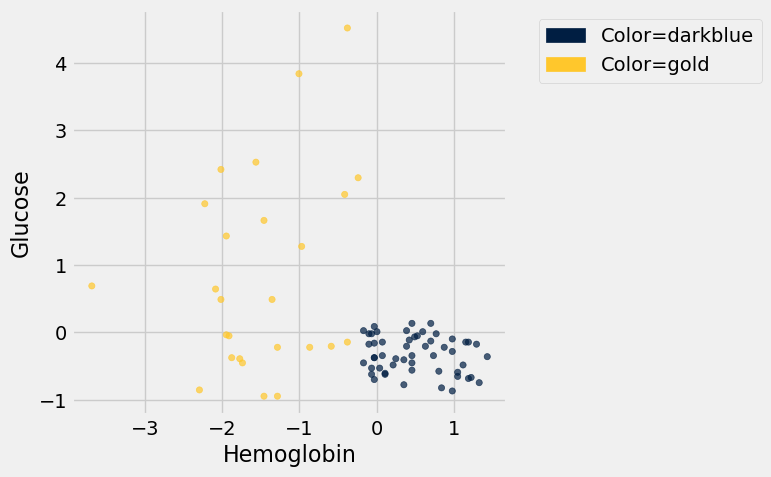

In [32]:
training.scatter('Hemoglobin', 'Glucose', group='Color')

#### Case study 2

- In the last example I "hard-coded" the halfway number (I knew what it was based on prior knowledge and so just entered the number). 

- That is somewhat inefficient, so I'm going to find out what it is (roughly) with code this time and save myself the energy.

In [33]:
halfway = round(banknotes.num_rows/2)
halfway

686

In [34]:
shuffled_banknotes = banknotes.sample(with_replacement=False)
training = shuffled_banknotes.take(np.arange(halfway))
testing = shuffled_banknotes.take(np.arange(halfway, banknotes.num_rows))

In [35]:
testing

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
2.0139,6.1416,0.37929,0.56938,0
-2.2918,-7.257,7.9597,0.9211,1
1.3403,4.1323,-4.7018,-2.5987,1
-2.902,-7.6563,11.8318,-0.84268,1
-6.3679,8.0102,0.4247,-3.2207,1
0.26517,2.4066,-2.8416,-0.59958,1
-0.16735,7.6274,1.2061,-3.6241,0
3.9922,-4.4676,3.7304,-0.1095,0
4.2458,1.1981,0.66633,0.94696,0
1.0652,8.3682,-1.4004,-1.6509,0


Here's a much more efficient way to do what we did in the previous two steps: use the built-in `Table.split()` function in the `datascience` library.

In [36]:
training, testing = banknotes.split(k = round(banknotes.num_rows/2))

_______

**Task**: Classify one point from the banknotes testing set. 

In [37]:
first_testing_banknote = banknotes.drop('Class').row(0)

In [38]:
first_testing_banknote

Row(WaveletVar=3.6215999999999999, WaveletSkew=8.6661000000000001, WaveletCurt=-2.8073000000000001, Entropy=-0.44699)

In [39]:
classify(training=training,p=first_testing_banknote,k=5)

0